<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Strato75/Covid-19_ItalyStats/blob/master/notebooks/whole_nation_stats.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" />Run in Google Colab</a>
  </td>
</table>

In [1]:
%pylab inline
import pandas as pd
from scipy.signal import savgol_filter
import requests
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

        
def get_df_from_json_url(url):
    response = requests.get(url)
    df = pd.read_json(response.text, orient='records')
    return df

In [3]:
raw_it_df = get_df_from_json_url('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json')
raw_it_df['data'] = pd.to_datetime(raw_it_df['data'], format='%Y-%m-%dT%H:%M:%S')

# Parameters for savgol filter (Smooting curves)
sliding_win_size = 15
polynomial_fit_degree = 3

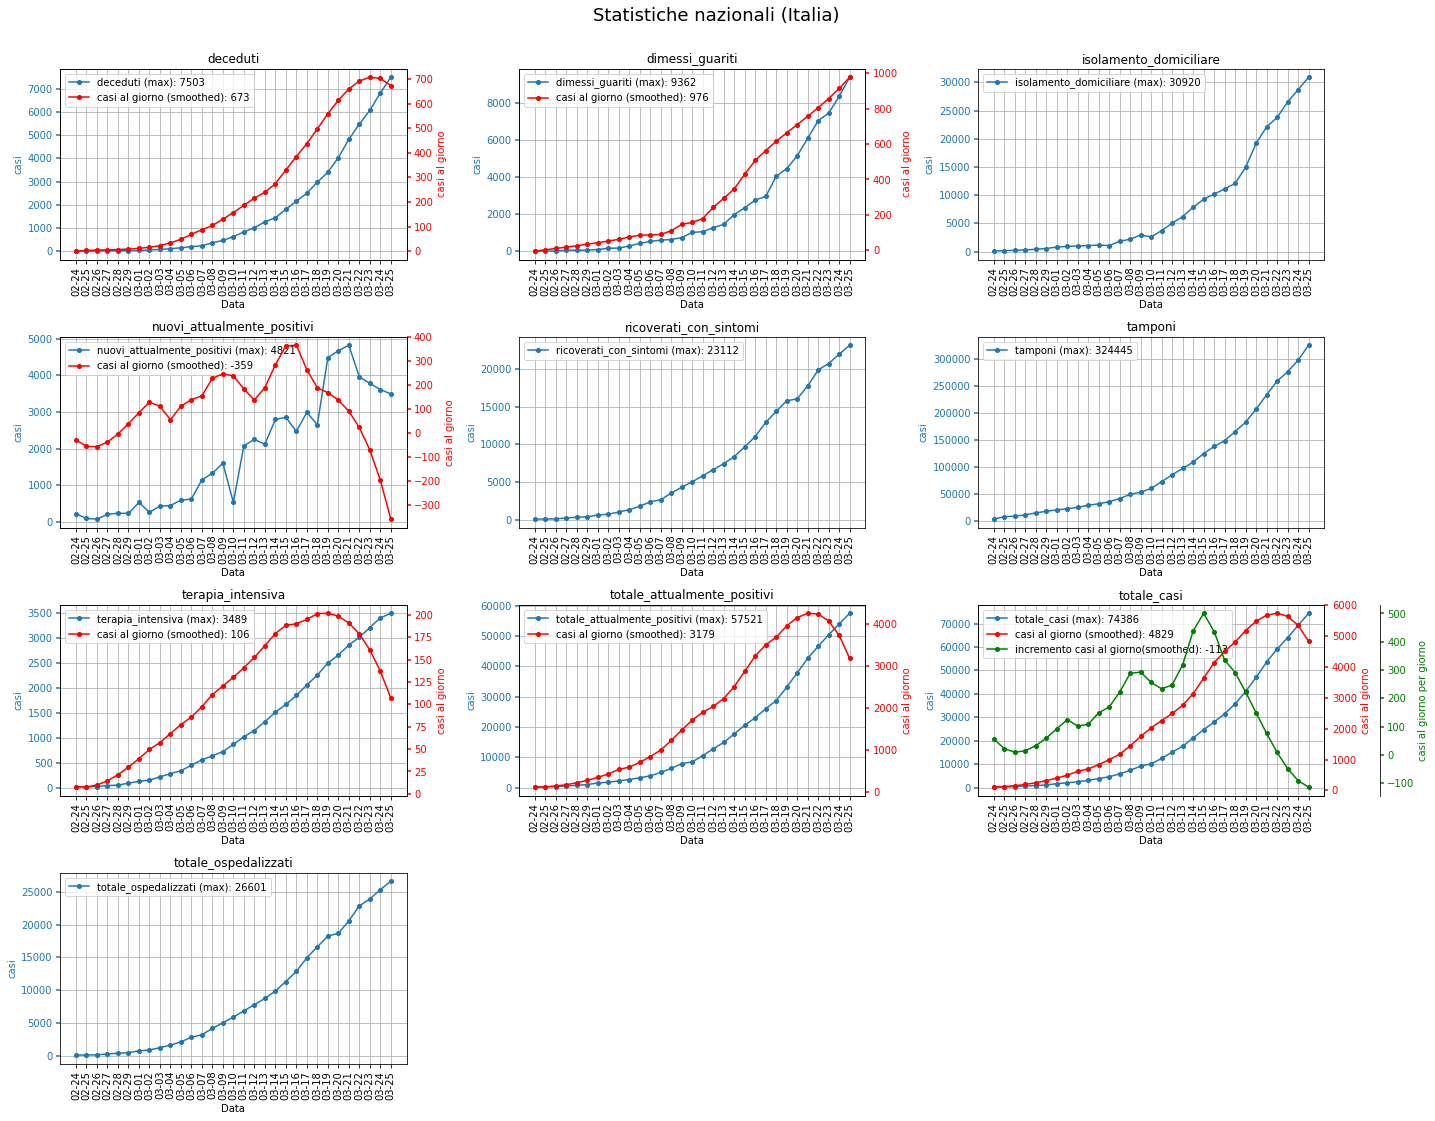

In [9]:
ms = 4
cols = raw_it_df.columns
fields = sorted(cols[2:-2])
grad_fields = ['totale_casi', 'nuovi_attualmente_positivi', 'terapia_intensiva', 'totale_attualmente_positivi', 'deceduti', 'dimessi_guariti']
grad2_fields = ['totale_casi']
fig = plt.figure(figsize=(20,16))

tkw = dict(size=4, width=1.5)

for index, field in enumerate(fields):
    ax0 = plt.subplot(4,3,index+1)
    x_data = ['-'.join(i.split('T')[0].split('-')[1:]) for i in np.datetime_as_string(raw_it_df['data'].values)] 
    data = raw_it_df[field]

    m = max(data)

    p1, = ax0.plot(x_data, data, 'o-', ms=ms, label=('%s (max): %d' % (field, m)))
    lines = [p1]
  
    if field in grad_fields:
        ax1 = ax0.twinx()
        grad = np.gradient(data)
        grad_hat = savgol_filter(grad, sliding_win_size, polynomial_fit_degree) 
        p2, = ax1.plot(x_data, grad_hat, 'o-', c='r', ms=ms, label=('casi al giorno (smoothed): %d' % grad_hat[-1]))
        #plot(x_data, grad, 'o-', ms=ms, label=('Derivative'))
        lines.append(p2)
        ax1.set_ylabel('casi al giorno')
        ax1.yaxis.label.set_color(p2.get_color())
        ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)

        if field in grad2_fields:
            ax2 = ax0.twinx()
            # Offset the right spine of par2.  The ticks and label have already been
            # placed on the right by twinx above.
            ax2.spines["right"].set_position(("axes", 1.16))
            # Having been created by twinx, par2 has its frame off, so the line of its
            # detached spine is invisible.  First, activate the frame but make the patch
            # and spines invisible.
            make_patch_spines_invisible(ax2)
            # Second, show the right spine.
            ax2.spines["right"].set_visible(True)

            grad2 = np.gradient(grad)
            grad2_hat = savgol_filter(grad2, sliding_win_size, polynomial_fit_degree) 
            p3, = ax2.plot(x_data, grad2_hat, 'o-', c='g', ms=ms, label=('incremento casi al giorno(smoothed): %d' % grad2_hat[-1]))
            #plot(x_data, grad, 'o-', ms=ms, label=('Derivative'))
            lines.append(p3)
            ax2.set_ylabel('casi al giorno per giorno')
            ax2.yaxis.label.set_color(p3.get_color())
            ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
        
    ax0.yaxis.label.set_color(p1.get_color())
    ax0.set_ylabel('casi')  
    ax0.set_xlabel('Data')
    ax0.grid()
    ax0.tick_params(axis='y', colors=p1.get_color(), **tkw)

    ax0.legend(lines, [l.get_label() for l in lines])
    ax0.set_title(field)
    _ = ax0.set_xticklabels(x_data, rotation=90)

plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Statistiche nazionali (Italia)", fontsize=18)
fig.savefig('figures/Italy_stats.png', transparent=False, dpi=300, bbox_inches='tight')